In [294]:
from scipy.stats import pearsonr, spearmanr, norminvgauss, invgauss, expon, entropy, gamma
from sklearn.model_selection import StratifiedKFold
import loompy
import anndata as ad
import scanpy as sc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import cmasher as cmr
from tqdm import tqdm
import copy
import pickle 
from multiprocessing import Pool

from utils import get_ensg_id, estimate_s, CCC

In [2]:
plt.rcParams['font.size'] = '12'
plt.rcParams['lines.linewidth'] = 4
plt.rcParams['lines.markersize'] = 12
plt.rcParams['figure.constrained_layout.use'] = True
label_font = '24'
legend_font = '18'
title_font = '30'

color_palette = ["#e07a5f","#3d405b","#81b29a","#f2cc8f","#98c1d9","#457b9d","#c74546","#613f75"]

from matplotlib.colors import LinearSegmentedColormap
cmap_cluster = LinearSegmentedColormap.from_list("my_cmap", color_palette, N=len(color_palette))

# EDA

## Load data

### Integrate data

**Download processed data**
```
wget  -O ./data/HSPC/rna.h5ad https://figshare.com/ndownloader/files/40064320
wget  -O ./data/HSPC/atac.h5ad https://figshare.com/ndownloader/files/40064311
```

In [169]:
### Download raw data
!mkdir data/HSPC
!curl  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6403nnn/GSM6403408/suppl/GSM6403408_3423-MV-1_gex_possorted_bam_0E7KE.loom.gz \
        --output ./data/HSPC/GSM6403408_3423-MV-1_gex_possorted_bam_0E7KE.loom.gz


!curl https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6403nnn/GSM6403409/suppl/GSM6403409_3423-MV-1_atac_fragments.tsv.gz \
        --output ./data/HSPC/GSM6403409_3423-MV-1_atac_fragments.tsv.gz 
!curl https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6403nnn/GSM6403409/suppl/GSM6403409_3423-MV-1_atac_fragments.tsv.gz.tbi.gz \
        --output ./data/HSPC/GSM6403409_3423-MV-1_atac_fragments.tsv.gz.tbi.gz
!curl https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM6403nnn/GSM6403409/suppl/GSM6403409_3423-MV-1_atac_peak_annotation.tsv.gz \
        --output ./data/HSPC/GSM6403409_3423-MV-1_atac_peak_annotation.tsv.gz

%cd ./data/HSPC/
!gunzip GSM6403408_3423-MV-1_gex_possorted_bam_0E7KE.loom.gz
!gunzip GSM6403409_3423-MV-1_atac_fragments.tsv.gz 
!gunzip GSM6403409_3423-MV-1_atac_fragments.tsv.gz.tbi.gz
!gunzip GSM6403409_3423-MV-1_atac_peak_annotation.tsv.gz
%cd ../../

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  156M  100  156M    0     0  17.0M      0  0:00:09  0:00:09 --:--:-- 26.9M
gzip: GSM6403408_3423-MV-1_gex_possorted_bam_0E7KE.loom.gz: No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 4104M  100 4104M    0     0  27.8M      0  0:02:27  0:02:27 --:--:-- 48.8M 0:02:32  0:01:46  0:00:46 21.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1560k  100 1560k    0     0  1890k      0 --:--:-- --:--:-- --:--:-- 1890k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2158k  10

In [174]:
%cd ./data/HSPC/
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE209nnn/GSE209878/suppl/GSE209878%5F3423%2DMV%2D1%5Fmatrix.mtx.gz

/home/mffang/workspace/Covariance/data/HSPC
--2024-02-14 12:21:48--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE209nnn/GSE209878/suppl/GSE209878%5F3423%2DMV%2D1%5Fmatrix.mtx.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.12, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 610277465 (582M) [application/x-gzip]
Saving to: ‘GSE209878_3423-MV-1_matrix.mtx.gz’

GSE209878_3423-MV-1 100%[===================>] 582.01M  24.5MB/s    in 30s     

2024-02-14 12:22:19 (19.5 MB/s) - ‘GSE209878_3423-MV-1_matrix.mtx.gz’ saved [610277465/610277465]



In [175]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE209nnn/GSE209878/suppl/GSE209878%5F3423%2DMV%2D1%5Fbarcodes.tsv.gz

--2024-02-14 12:22:56--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE209nnn/GSE209878/suppl/GSE209878%5F3423%2DMV%2D1%5Fbarcodes.tsv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 2607:f220:41e:250::11, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 48912 (48K) [application/x-gzip]
Saving to: ‘GSE209878_3423-MV-1_barcodes.tsv.gz’

GSE209878_3423-MV-1 100%[===================>]  47.77K  --.-KB/s    in 0.1s    

2024-02-14 12:22:56 (394 KB/s) - ‘GSE209878_3423-MV-1_barcodes.tsv.gz’ saved [48912/48912]



In [176]:
!wget https://ftp.ncbi.nlm.nih.gov/geo/series/GSE209nnn/GSE209878/suppl/GSE209878%5F3423%2DMV%2D1%5Ffeatures.tsv.gz

--2024-02-14 12:23:14--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE209nnn/GSE209878/suppl/GSE209878%5F3423%2DMV%2D1%5Ffeatures.tsv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.12, 130.14.250.13, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3551910 (3.4M) [application/x-gzip]
Saving to: ‘GSE209878_3423-MV-1_features.tsv.gz’

GSE209878_3423-MV-1 100%[===================>]   3.39M  6.11MB/s    in 0.6s    

2024-02-14 12:23:15 (6.11 MB/s) - ‘GSE209878_3423-MV-1_features.tsv.gz’ saved [3551910/3551910]



In [177]:
!gunzip GSE209878_3423-MV-1_barcodes.tsv.gz
!gunzip GSE209878_3423-MV-1_features.tsv.gz
!gunzip GSE209878_3423-MV-1_matrix.mtx.gz

In [178]:
%cd ../../

/home/mffang/workspace/Covariance


In [173]:
raw_rna = sc.read('data/HSPC/GSM6403408_3423-MV-1_gex_possorted_bam_0E7KE.loom',validate=False)
raw_rna

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 9757 × 36601
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'spliced', 'unspliced'

In [196]:
alldata = raw_rna.copy()
alldata.obs

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


""
CellID
gex_possorted_bam_0E7KE:AAAGGCTCAAGCTAAAx
gex_possorted_bam_0E7KE:AAACATGCAAGGTAACx
gex_possorted_bam_0E7KE:AAAGCCGCATGATTGTx
gex_possorted_bam_0E7KE:AAAGCTTGTGTTAAACx
gex_possorted_bam_0E7KE:AAAGCAAGTTCGCGCTx
...
gex_possorted_bam_0E7KE:TTTGTCCCACGAATTTx
gex_possorted_bam_0E7KE:TTTGGCTGTCTAGCTTx
gex_possorted_bam_0E7KE:TTTGTGAAGCGCTCAAx


In [197]:
### Load RNA data
ID = np.array([cell[-17:-1] + "-1" for cell in raw_rna.obs_names],dtype=str)
alldata.obs_names = ID
alldata.obs

""
AAAGGCTCAAGCTAAA-1
AAACATGCAAGGTAAC-1
AAAGCCGCATGATTGT-1
AAAGCTTGTGTTAAAC-1
AAAGCAAGTTCGCGCT-1
...
TTTGTCCCACGAATTT-1
TTTGGCTGTCTAGCTT-1
TTTGTGAAGCGCTCAA-1
TTTGTGAAGGCAGGTG-1


In [184]:
### Load ATAC data

# Load the barcode feature matrix from the MTX file
matrix_file = "data/HSPC/GSE209878_3423-MV-1_matrix.mtx"
matrix = scipy.io.mmread(matrix_file)

# Load the barcode information from the barcode TSV file
barcode_file = "data/HSPC/GSE209878_3423-MV-1_barcodes.tsv"
barcode_df = pd.read_csv(barcode_file, delimiter='\t', header=None, names=["barcode"])
barcode_df

,barcode
0,AAACAGCCACCACAAC-1
1,AAACAGCCACCGGTAT-1
2,AAACAGCCACTGACCG-1
3,AAACAGCCAGTAAAGC-1
4,AAACATGCAAGGTAAC-1
...,...
9752,TTTGTTGGTGCACGCA-1
9753,TTTGTTGGTGGAGCAA-1
9754,TTTGTTGGTTGACTTC-1
9755,TTTGTTGGTTTATCGC-1


In [190]:
# Load the feature information from the feature TSV file
feature_file = "data/HSPC/GSE209878_3423-MV-1_features.tsv"
feature_df = pd.read_csv(feature_file, delimiter='\t', header=None, names=["ensembl_id", "gene_name", "type", "chromosome", "start", "end"])
# Filter the feature information to extract "Peaks"
peaks_df = feature_df[feature_df['type'] == "Peaks"]

# Get the indices of the "Peaks" features in the barcode feature matrix
peaks_indices = [feature_df.index.get_loc(idx) for idx in peaks_df.index]

# Extract the count matrix of "Peaks" from the barcode feature matrix
peaks_matrix = matrix.tocsr()[peaks_indices, :]

# Read the peak annotation file
peak_annotation_file = "data/HSPC/GSM6403409_3423-MV-1_atac_peak_annotation.tsv"
peak_annotation_df = pd.read_csv(peak_annotation_file, delimiter='\t')

# Create a dictionary to map coordinates to gene names
coord_to_gene = {}
for _, row in peak_annotation_df.iterrows():
    coord = (row['chrom'], row['start'], row['end'])
    gene_name = row['gene']
    coord_to_gene[coord] = gene_name

# Get the gene names for each entry in peaks_df
gene_names = []
for _, row in peaks_df.iterrows():
    coord = (row['chromosome'], row['start'], row['end'])
    gene_name = coord_to_gene.get(coord, "")
    gene_names.append(gene_name)

# Add the "gene_name" column to peaks_df
peaks_df.loc[:, 'gene_name'] = gene_names

# Print the updated peaks_df
print(peaks_df)

atac_matrix = peaks_matrix.transpose().toarray()

/tmp/ipykernel_1844069/1014825097.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  peaks_df.loc[:, 'gene_name'] = gene_names


                    ensembl_id    gene_name   type  chromosome   start     end
36601          chr1:9796-10689  MIR1302-2HG  Peaks        chr1    9796   10689
36602       chr1:181093-181816   AL627309.5  Peaks        chr1  181093  181816
36603       chr1:183955-184748   AL627309.5  Peaks        chr1  183955  184748
36604       chr1:186388-187219   AL627309.5  Peaks        chr1  186388  187219
36605       chr1:191102-192024   AL627309.5  Peaks        chr1  191102  192024
...                        ...          ...    ...         ...     ...     ...
183484  KI270713.1:21400-22280   AC213203.2  Peaks  KI270713.1   21400   22280
183485  KI270713.1:29586-30482   AC213203.2  Peaks  KI270713.1   29586   30482
183486  KI270713.1:31391-32188   AC213203.2  Peaks  KI270713.1   31391   32188
183487  KI270713.1:33237-33776   AC213203.2  Peaks  KI270713.1   33237   33776
183488  KI270713.1:36924-37815   AC213203.1  Peaks  KI270713.1   36924   37815

[146888 rows x 6 columns]


In [198]:
cell_idx = np.array([ np.where(barcode_df['barcode']==obs_name)[0][0] for obs_name in alldata.obs_names],dtype=int)

share_genes = alldata.var_names[alldata.var_names.isin(peaks_df['gene_name'])]
gene_idx = np.array([ np.where(peaks_df['gene_name']==var_name)[0][0] for var_name in share_genes],dtype=int)
gene_idx_alldata = np.array([np.where(alldata.var_names==var_name)[0][0] for var_name in share_genes],dtype=int)

alldata = alldata[:,gene_idx_alldata]
alldata.layers['atac'] = scipy.sparse.csr_matrix(atac_matrix[cell_idx][:,gene_idx])
alldata.write_loom('data/HSPC.loom',write_obsm_varm=True)

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


### Load loom file

In [199]:
alldata=ad.read_loom('data/HSPC.loom',validate=False)
alldata

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:117: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 9757 × 29184
    obs: 'obs_names'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'matrix', 'ambiguous', 'atac', 'spliced', 'unspliced'

**Define marker genes**

In [201]:
marker_genes = [g.upper() for g in ['Smim1','Hba-x','Abcg2','Cnn3','Scube2','Klf1','Gata1','Gata2','Cd45',"FLI1"] ]
plot_marker_genes = alldata.var_names[alldata.var_names.isin(marker_genes)]
plot_marker_genes

Index(['CNN3', 'SMIM1', 'SCUBE2', 'FLI1', 'KLF1', 'GATA2', 'ABCG2', 'GATA1'], dtype='object', name='Gene')

**PCA plots and marker gene expresssion**

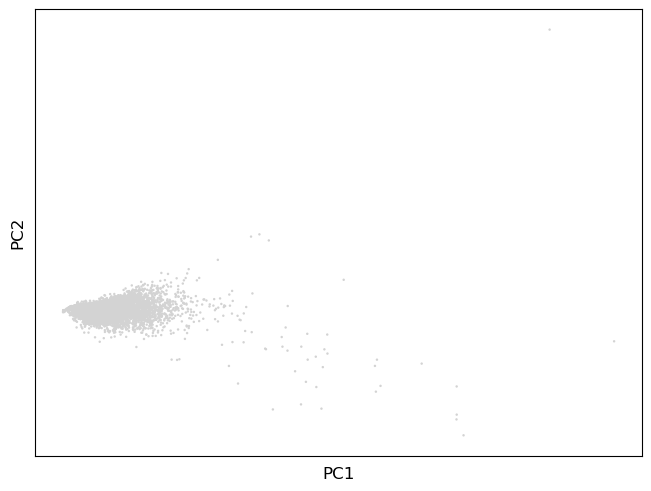

In [204]:
sc.tl.pca(alldata)
sc.pl.pca(alldata)

In [205]:
adata = alldata.copy()
adata

/home/mffang/miniconda3/envs/python_3.8/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 9757 × 29184
    obs: 'obs_names'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'atac', 'spliced', 'unspliced'

## Genes variances

0.33436863367550784 0.0997769651208579 0.11224285218529567


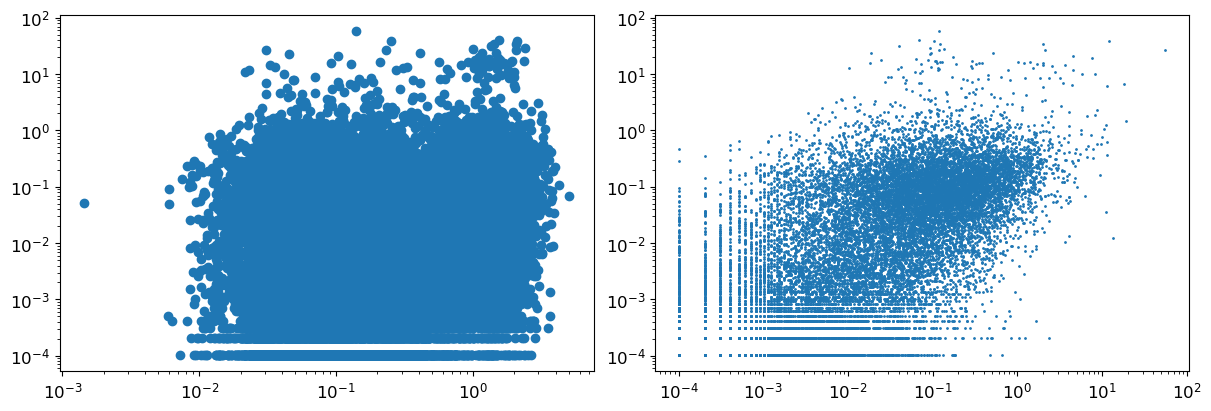

In [206]:
fig, ax = plt.subplots(1,2,figsize=(12,4))
ax[0].loglog(adata.layers['atac'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),'.')
ax[1].scatter(adata.layers['unspliced'].toarray().mean(0),adata.layers['spliced'].toarray().mean(0),s=1)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
print(adata.layers['atac'].toarray().mean(),adata.layers['unspliced'].toarray().mean(),adata.layers['spliced'].toarray().mean())

Text(0.02, 0.5, 'CV$^2$')

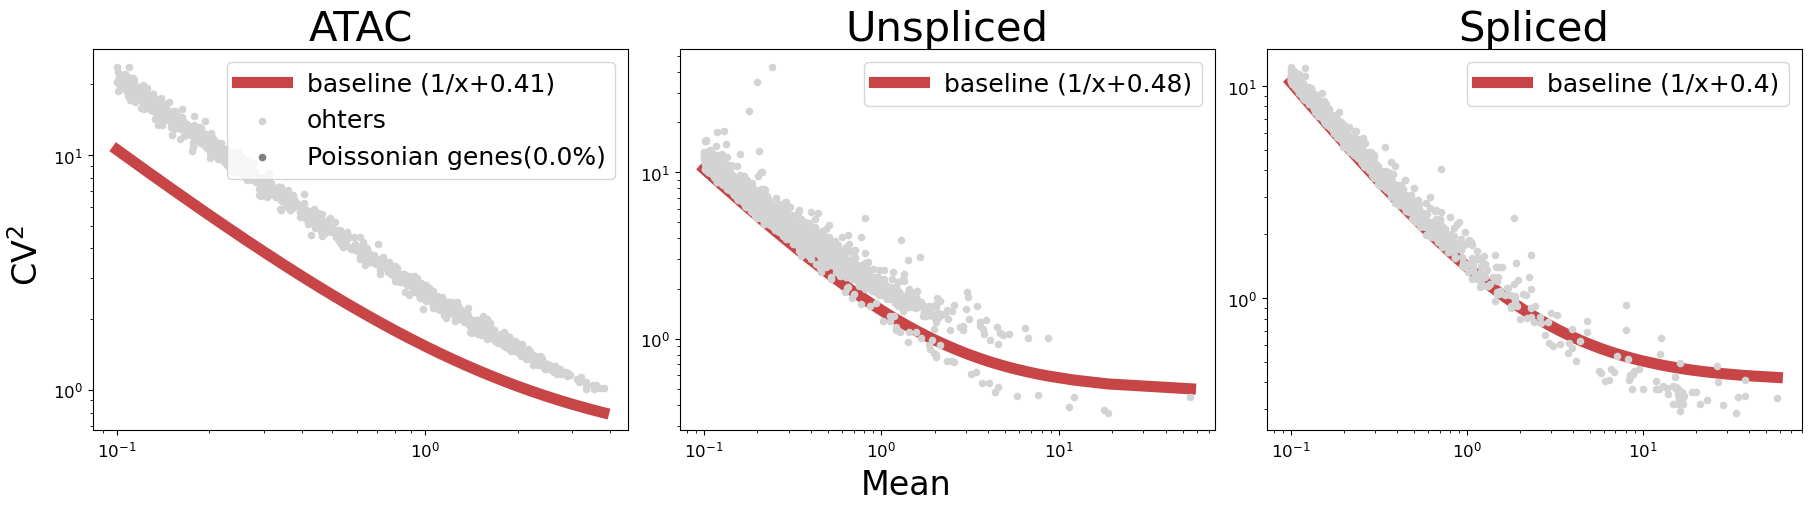

In [348]:
idx = (adata.layers["atac"].toarray().mean(0) > 0.1) & (adata.layers["spliced"].toarray().mean(0) > 0.1) & (adata.layers["unspliced"].toarray().mean(0) > 0.1)
G = adata.layers["atac"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
U = adata.layers["unspliced"][:,idx].toarray()

X = G
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), 1/np.sort(X_mean) + sg, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray', label='Poissonian genes('+str(np.around(100*np.sum(Pgene_mask)/len(X_mean),1))+"%)")
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('ATAC',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + su, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), 1/np.sort(S_mean) + ss, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray')
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

In [396]:
def estimate_s(adata,layers=["spliced","spliced"],n_iter=10,min_mean=0.1,var_threshold=1.2):
    idx = (adata.layers[layers[0]].toarray().mean(0) > min_mean) & (adata.layers[layers[1]].toarray().mean(0) > min_mean)
    A = adata.layers[layers[0]][:,idx].toarray()
    B = adata.layers[layers[1]][:,idx].toarray()
    A_mean = A.mean(0)
    B_mean = B.mean(0)

    X = np.concatenate((A,B),axis=1)
    X_mean = X.mean(0)
    P = len(X_mean)
    p = P//2
    eta = np.cov(X,rowvar=False)/X_mean[:,None]/X_mean[None,:]
    eta_ = eta[p:,:p]
    X_cv2 = np.diagonal(eta_.copy())
    s = (np.sum(eta_)-np.sum(X_cv2))/((p-1)*p)
    print(s,p)

    for i in range(n_iter):
        if layers[0] == layers[1]:
            Pgene_mask = (X_cv2 - 1/A_mean < s*var_threshold)
        else:
            Pgene_mask = (X_cv2 < s*var_threshold)
            
        print(Pgene_mask.sum(),"s=", str(s))
        P = np.concatenate((A[:,Pgene_mask],B[:,Pgene_mask]),axis=1)
        p = Pgene_mask.sum()
        eta = np.cov(P,rowvar=False)/P.mean(0)[:,None]/P.mean(0)[None,:]
        eta_ = eta[p:,:p]
        s = (np.sum(eta_)-np.sum(np.diagonal(eta_)))/((p-1)*p)
    
    np.fill_diagonal(eta_, np.nan)
    eta_ = eta_.flatten()
    eta_ = eta_[~np.isnan(eta_)]
    hist, bins, patches = plt.hist(eta_.flatten(),bins=np.arange(-1,1.5,0.01));
    s = bins[np.argmax(hist)]
    plt.axvline(x=s,c='r',zorder=0)
    return s

0.7042920184838649 15169
2541 s= 0.7042920184838649
851 s= 0.5229852858844996
649 s= 0.49852830220356514
619 s= 0.49502164912778823
615 s= 0.4945816273262211
614 s= 0.4942577582040843
613 s= 0.49422825917447905
613 s= 0.49420350158546544
613 s= 0.49420350158546544
613 s= 0.49420350158546544


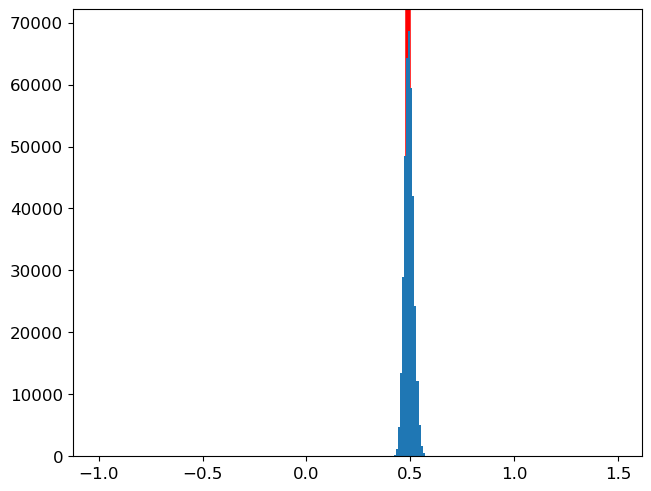

In [405]:
s_gg = estimate_s(adata,layers=["atac","atac"],min_mean=0.1,var_threshold=2)

0.3814366166830096 2726
2029 s= 0.3814366166830096
1737 s= 0.3423014710291517
1602 s= 0.3291271700385821
1552 s= 0.32419428908521536
1532 s= 0.3223423170097687
1520 s= 0.32116940830433366
1518 s= 0.32087435498834815
1518 s= 0.3207961859389635
1518 s= 0.3207961859389635
1518 s= 0.3207961859389635


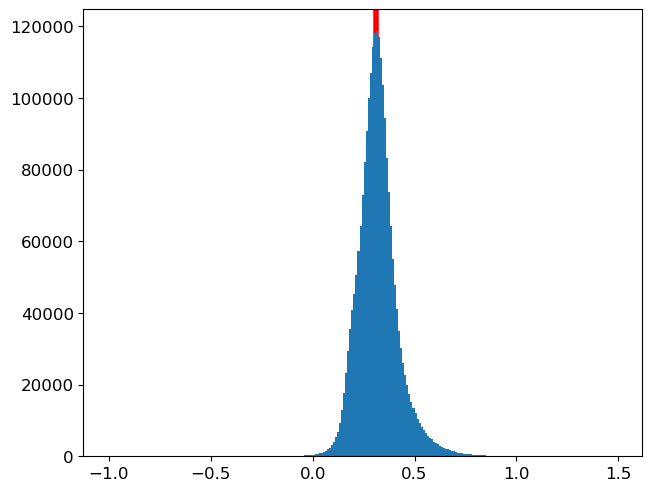

In [402]:
s_gu = estimate_s(adata,layers=["atac","unspliced"],min_mean=0.1,var_threshold=1.2)

0.29130606928845376 2860
2123 s= 0.29130606928845376
1776 s= 0.25778279137141735
1632 s= 0.2462900900603279
1565 s= 0.24168664799010042
1540 s= 0.23974376522440766
1535 s= 0.23904346032122234
1534 s= 0.2388321607791573
1534 s= 0.23881784887090066
1534 s= 0.23881784887090066
1534 s= 0.23881784887090066


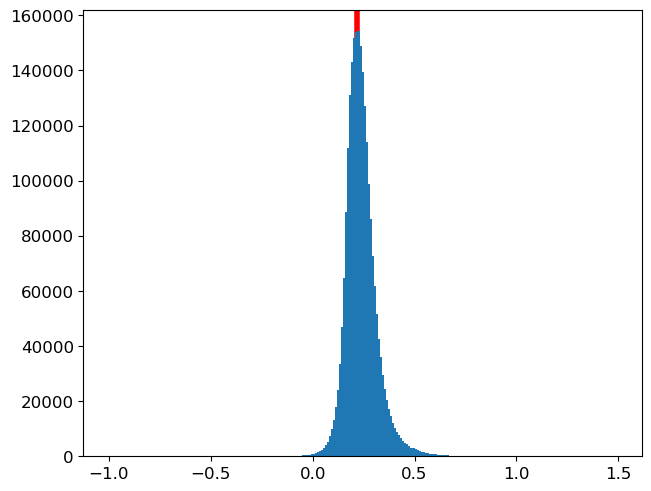

In [403]:
s_gs = estimate_s(adata,layers=["atac","spliced"],min_mean=0.1,var_threshold=1.2)

0.5120890883471657 11516
354 s= 0.5120890883471657
186 s= 0.32929886854952123
177 s= 0.3175559179903619
176 s= 0.31679352418973106
176 s= 0.3163195745428723
176 s= 0.3163195745428723
176 s= 0.3163195745428723
176 s= 0.3163195745428723
176 s= 0.3163195745428723
176 s= 0.3163195745428723


0.2600000000000011

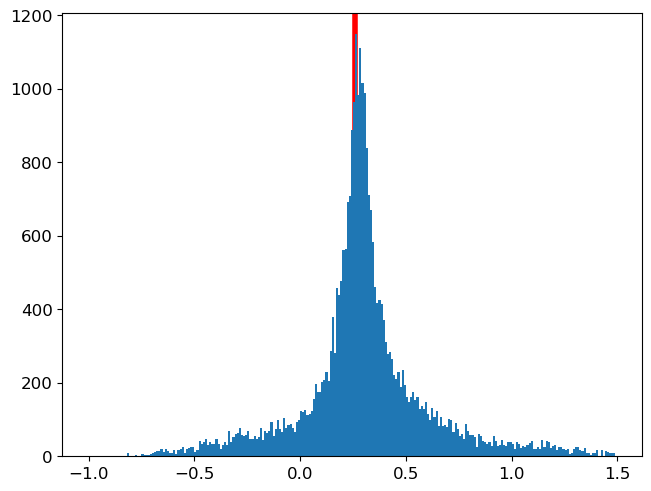

In [399]:
estimate_s(adata,layers=["unspliced","unspliced"],min_mean=0.01)

0.45813161596318835 2472
1060 s= 0.45813161596318835
567 s= 0.38784407091700024
383 s= 0.3525138304729092
309 s= 0.33373858001776135
279 s= 0.3247002760646784
255 s= 0.3195761283775617
243 s= 0.31520493730471616
238 s= 0.31412016546101584
234 s= 0.31361637317381863
237 s= 0.31395527552125624


0.28000000000000114

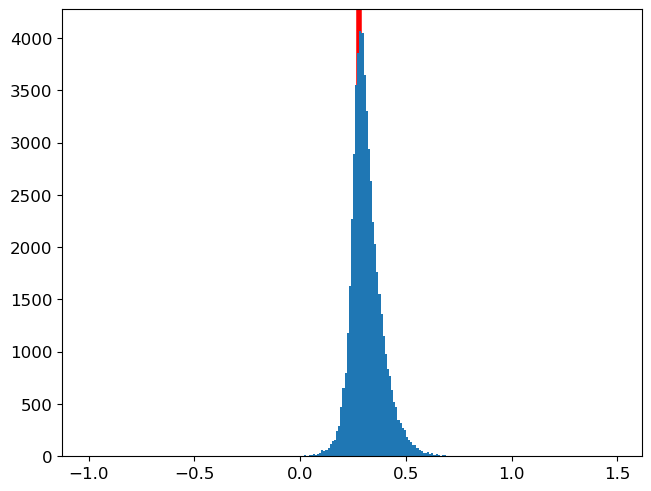

In [400]:
estimate_s(adata,layers=["unspliced","spliced"])

0.39301548061346514 4552
867 s= 0.39301548061346514
330 s= 0.3077936677584887
228 s= 0.28373253897713147
208 s= 0.27760343333302256
203 s= 0.2759265510458321
203 s= 0.2759316620615442
203 s= 0.2759316620615442
203 s= 0.2759316620615442
203 s= 0.2759316620615442
203 s= 0.2759316620615442


0.27000000000000113

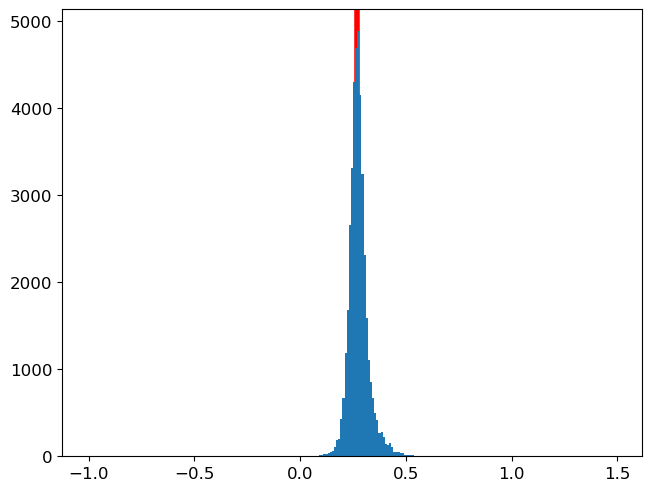

In [401]:
estimate_s(adata,layers=["spliced","spliced"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


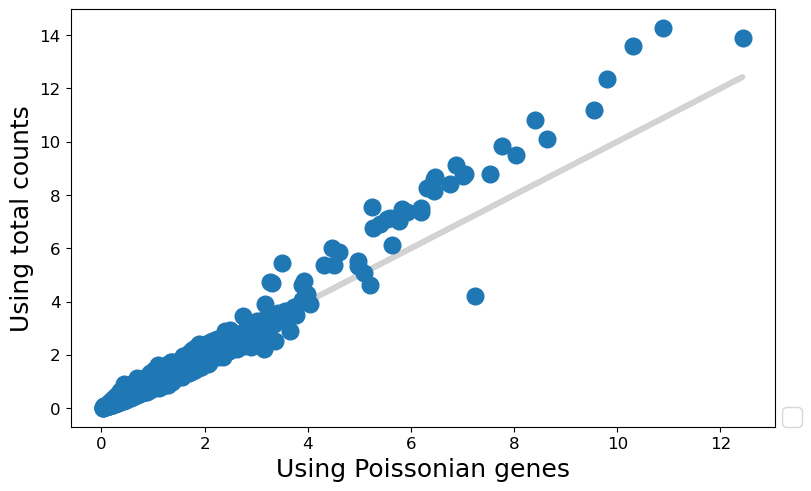

In [209]:
rd = X[:,Pgene_mask].mean(1)/X[:,Pgene_mask].mean()
rd_ = X.mean(1)/X.mean()
fig, ax = plt.subplots(1,1,figsize=(8,4.8))
ax.scatter(rd,rd_)
ax.plot(rd,rd,color='lightgray',zorder=0)
plt.xlabel('Using Poissonian genes',fontsize=legend_font)
plt.ylabel('Using total counts',fontsize=legend_font)
plt.legend(loc=(1.01,0),fontsize=legend_font)

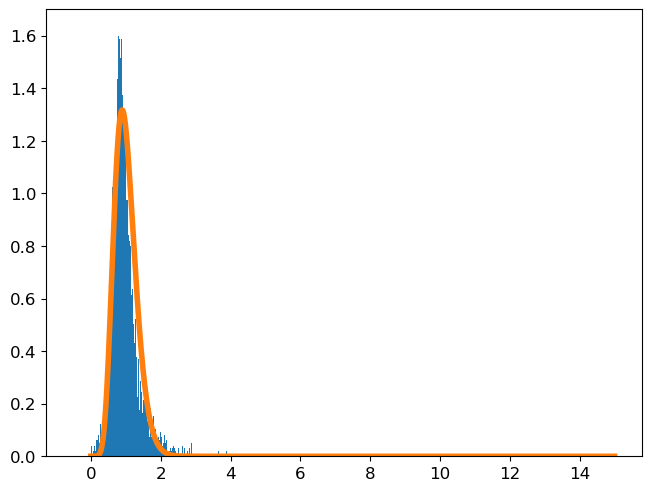

In [299]:
x = np.arange(0,15,0.01)
s = 0.1
plt.hist(rd,bins=x-0.5, density=True);
plt.plot(x,gamma.pdf(x, a=1/s,scale=s))

## Select cells

In [429]:
adata = alldata#[rd<5]
adata

AnnData object with n_obs × n_vars = 9757 × 29184
    obs: 'obs_names'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'matrix', 'ambiguous', 'atac', 'spliced', 'unspliced'

In [430]:
su=ss=sp=s=0.27
s_gg=0.5

Text(0.02, 0.5, 'CV$^2$')

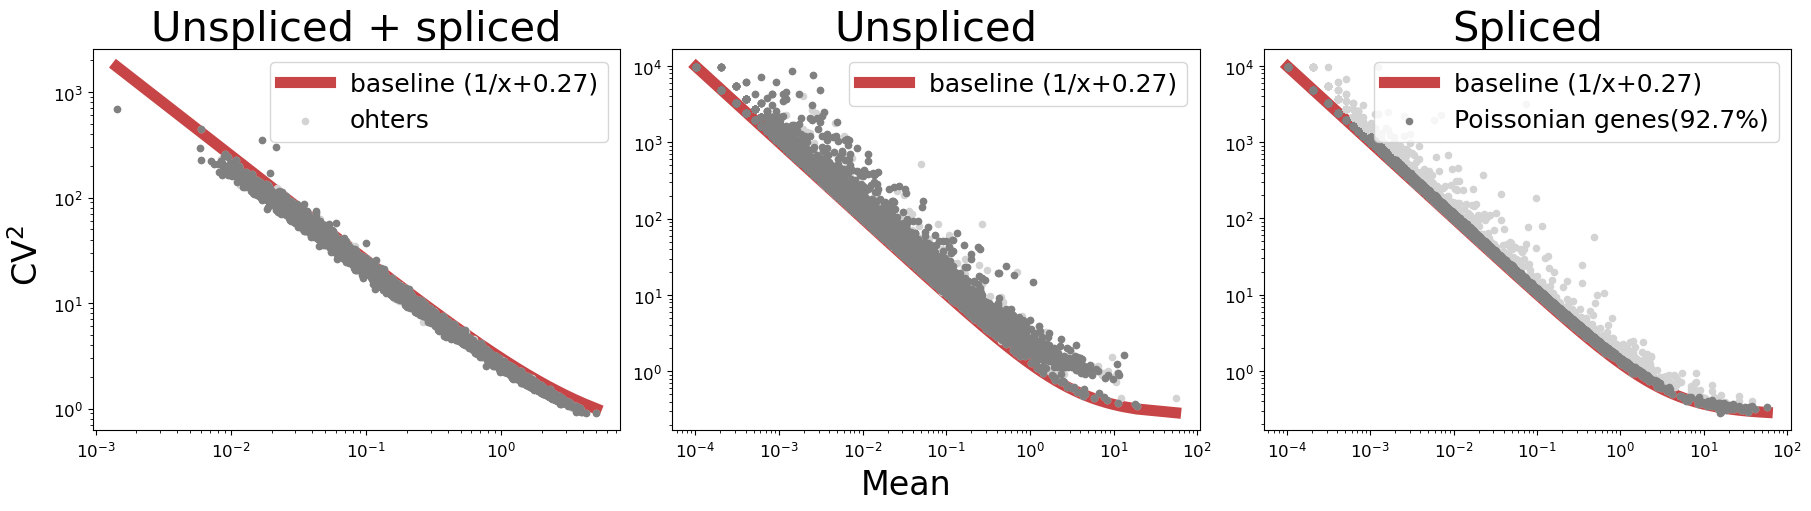

In [441]:
idx =  (adata.layers["atac"].toarray().mean(0) > 0.0)\
        & (adata.layers["spliced"].toarray().mean(0) > 0.0)\
        & (adata.layers["unspliced"].toarray().mean(0) > 0.0)

G = adata.layers["atac"][:,idx].toarray()
U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()

X = G
S_mean = np.mean(S,axis=0)
U_mean = np.mean(U,axis=0)
X_mean = np.mean(X,axis=0)
X_var = np.var(X,axis=0)
S_var = np.var(S,axis=0)
U_var = np.var(U,axis=0)

Pgene_mask = (S_var/(S_mean + s*S_mean**2) < 1.2)   

fig, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].plot(np.sort(X_mean), (1+1*(1+s_gg))/np.sort(X_mean) + s_gg, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(sp,2))+")")
ax[0].scatter(X_mean, X_var/X_mean**2,c='lightgray',alpha=1, s=20,label='ohters')
ax[0].scatter(X_mean[Pgene_mask], X_var[Pgene_mask]/X_mean[Pgene_mask]**2, s=20, c='gray')
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_title('Unspliced + spliced',fontsize=title_font)
ax[0].legend(fontsize=legend_font)

ax[1].plot(np.sort(U_mean), 1/np.sort(U_mean) + s, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(su,2))+")")
ax[1].scatter(U_mean, U_var/U_mean**2,c='lightgray',alpha=1, s=20)
ax[1].scatter(U_mean[Pgene_mask], U_var[Pgene_mask]/U_mean[Pgene_mask]**2, s=20, c='gray')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_title('Unspliced',fontsize=title_font)
ax[1].legend(fontsize=legend_font)

ax[2].plot(np.sort(S_mean), 1/np.sort(S_mean) + s, color='#c74546', linewidth=8, zorder=0, label='baseline (1/x+'+str(np.around(ss,2))+")")
ax[2].scatter(S_mean, S_var/S_mean**2,c='lightgray',alpha=1, s=20)
ax[2].scatter(S_mean[Pgene_mask], S_var[Pgene_mask]/S_mean[Pgene_mask]**2, s=20, c='gray',\
              label='Poissonian genes('+str(np.around(100*np.mean(Pgene_mask),1))+"%)")
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_title('Spliced',fontsize=title_font)
ax[2].legend(fontsize=legend_font)

fig.supxlabel('Mean',fontsize=label_font)
fig.supylabel(r'CV$^2$',fontsize=label_font)

0.38692986896125076


Text(0.5, 1.0, 'U+S+A')

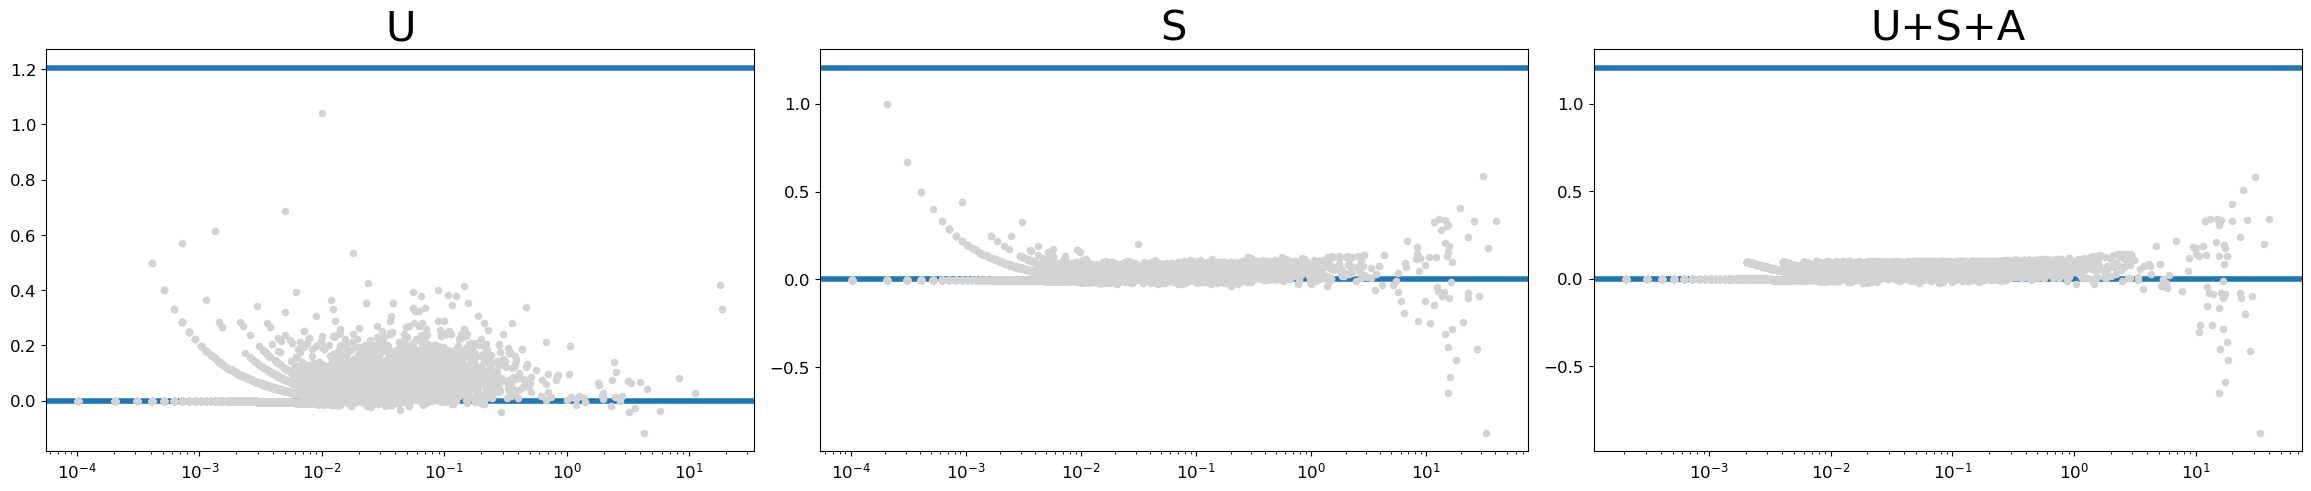

In [250]:
Pgene_mask = (X_var/(X_mean + sp*X_mean**2) < 1.1)   
print(Pgene_mask.mean())
s=sp
def f(X):
    mean = np.mean(X,axis=0)
    var = np.var(X,axis=0)
    return var/mean-s*mean-1

fig, ax = plt.subplots(1,3,figsize=(23,4.8))
ax[0].scatter(U_mean[Pgene_mask], f(U[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[0].axhline(y=0,zorder=0)
ax[0].axhline(y=1+s,zorder=0)
ax[0].set_xscale('log')
ax[0].set_title('U',fontsize=title_font)

ax[1].scatter(S_mean[Pgene_mask], f(S[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[1].axhline(y=0,zorder=0)
ax[1].axhline(y=1+s,zorder=0)
ax[1].set_xscale('log')
ax[1].set_title('S',fontsize=title_font)

X_ = S + U 
ax[2].scatter(X_mean[Pgene_mask], f(X_[:,Pgene_mask]),c='lightgray',alpha=1, s=20)
ax[2].axhline(y=0,zorder=0)
ax[2].axhline(y=1+s,zorder=0)
ax[2].set_xscale('log')
ax[2].set_title('U+S+A',fontsize=title_font)

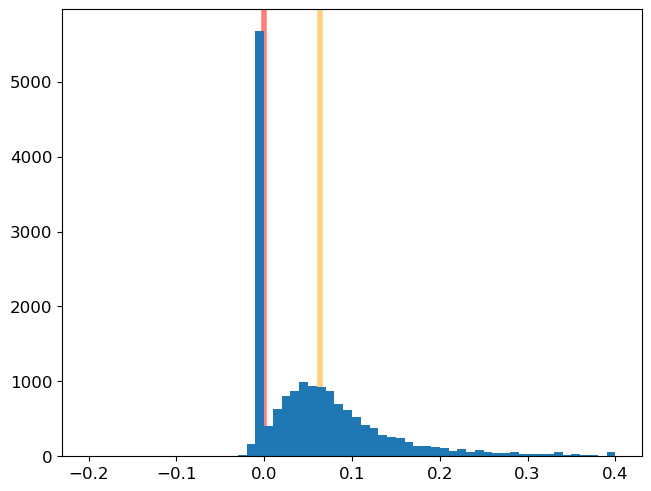

In [443]:
plt.hist((S_var-S_mean)/S_mean-s*S_mean,bins=np.arange(-0.2,0.4,0.01));
plt.axvline(x=0,c='r',zorder=0,alpha=0.5)
plt.axvline(x=0.05*(1+s),c='orange',zorder=0,alpha=0.5)

# Check covariance relationships

In [431]:
mean_min = 0.25

idx = (adata.layers["atac"].toarray().mean(0) > 2*mean_min) & (adata.layers["spliced"].toarray().mean(0) > mean_min) & (adata.layers["unspliced"].toarray().mean(0) > mean_min)

U = adata.layers["unspliced"][:,idx].toarray()
S = adata.layers["spliced"][:,idx].toarray()
G = adata.layers["atac"][:,idx].toarray()

S_mean = np.mean(S,axis=0)
G_mean = np.mean(G,axis=0)
U_mean = np.mean(U,axis=0)

S_var = np.var(S,axis=0)
G_var = np.var(G,axis=0)
U_var = np.var(U,axis=0)

eta_gg = (G_var-G_mean)/G_mean**2
zeta_uu = (U_var-U_mean)/U_mean**2
zeta_ss = (S_var-S_mean)/S_mean**2

cov_gu = []
cov_gs = []
cov_us = []
for i in np.arange(len(U_mean)):
    cov_gu.append(np.cov(U[:,i],G[:,i])[0,1])
    cov_gs.append(np.cov(G[:,i],S[:,i])[0,1])
    cov_us.append(np.cov(U[:,i],S[:,i])[0,1])
cov_gu = np.array(cov_gu)
cov_gs = np.array(cov_gs)
cov_us = np.array(cov_us)
zeta_gu = (cov_gu)/G_mean/U_mean
zeta_gs = (cov_gs)/S_mean/G_mean
zeta_us = (cov_us)/S_mean/U_mean
zeta_us.shape

(182,)

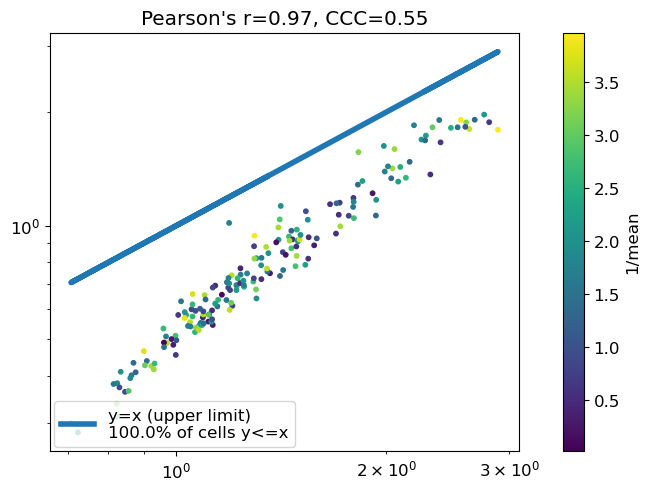

In [432]:
x=eta_gg
y=1/G_mean

plt.loglog(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean)
plt.title("Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)));
plt.colorbar(label='1/mean')
plt.legend(loc=(0.01,0.01))

Text(0.5, 1.0, '100.0% of cells >= 0')

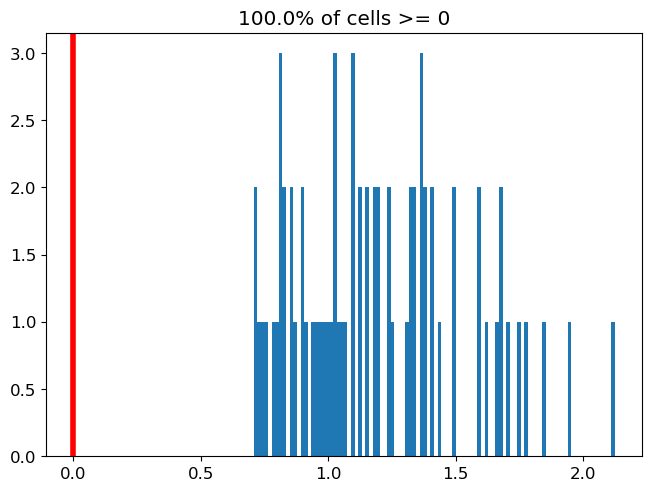

In [433]:
plt.hist(zeta_gg,bins=100);
plt.axvline(x=0,c='r')
plt.title(str(np.around(100*(zeta_gg>=0).mean(),2))+'% of cells >= 0')

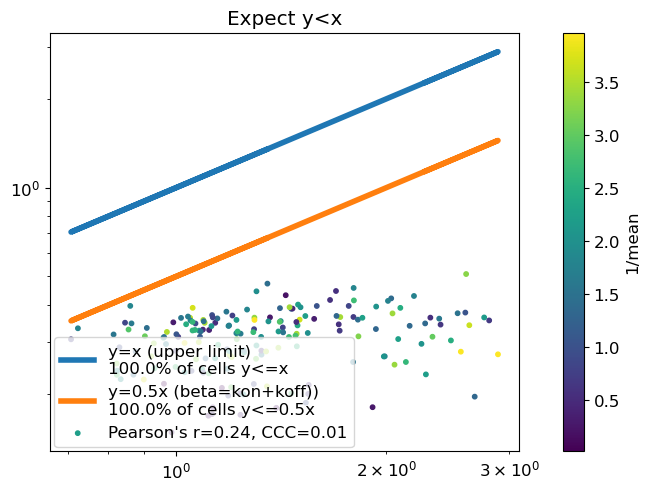

In [434]:
x=eta_gg
y=zeta_gu

plt.loglog(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=kon+koff))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean,label="Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)))
plt.title("Expect y<x");
plt.colorbar(label='1/mean')
plt.legend(loc=(0.01,0.01))

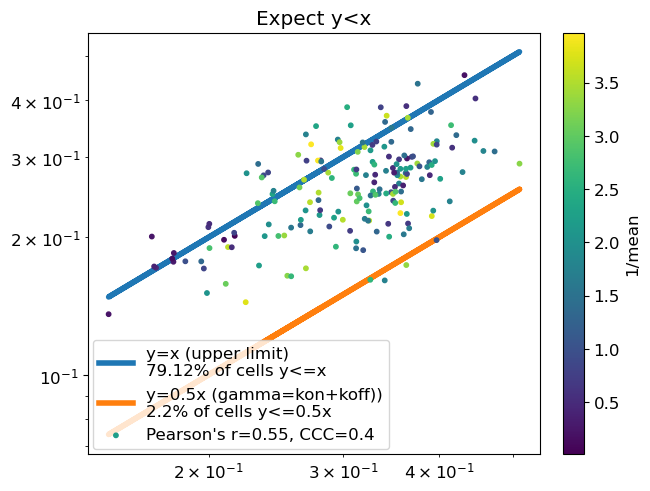

In [435]:
x=zeta_gu
y=zeta_gs

plt.loglog(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (gamma=kon+koff))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean,label="Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)))
plt.title("Expect y<x");
plt.colorbar(label='1/mean')
plt.legend(loc=(0.01,0.01))

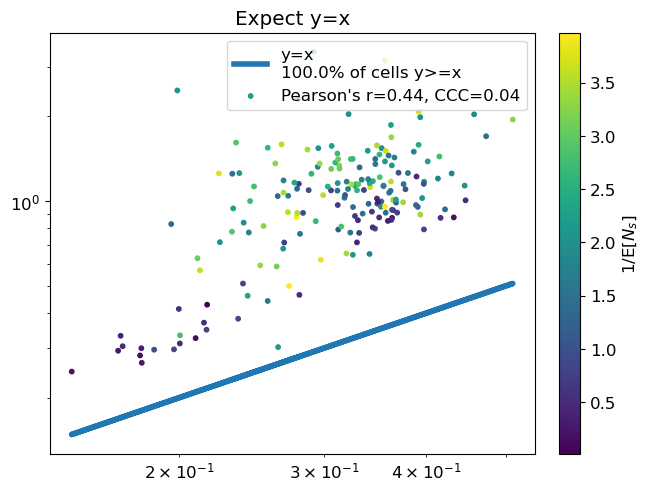

In [436]:
x=zeta_gu
y=zeta_uu

plt.loglog(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x<=y).mean(),2))+'% of cells y>=x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean,label="Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)))
plt.title("Expect y=x");
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()

Text(0.5, 1.0, '100.0% of cells >= 0')

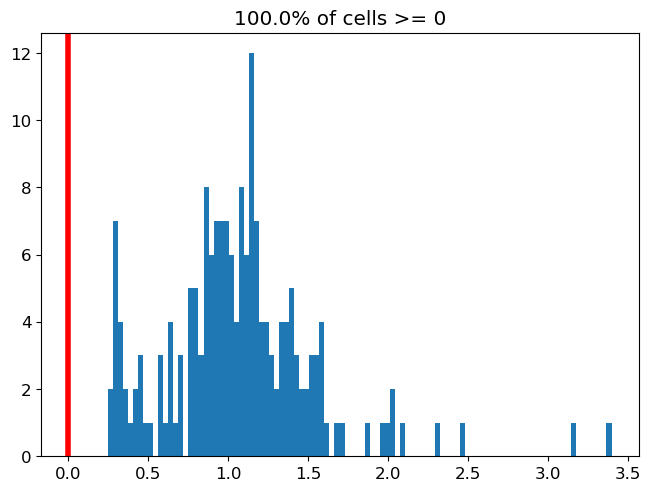

In [437]:
plt.hist(zeta_uu,bins=100);
plt.axvline(x=0,c='r')
plt.title(str(np.around(100*(zeta_uu>=0).mean(),2))+'% of cells >= 0')

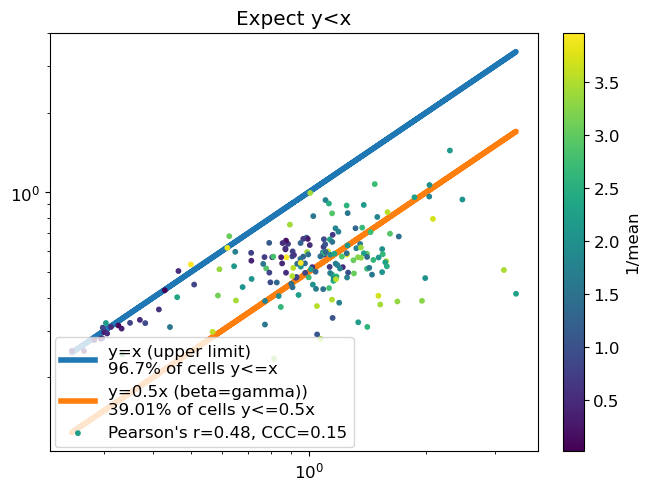

In [438]:
x=zeta_uu
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x (upper limit)\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/U_mean,label="Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)))
plt.title("Expect y<x");
plt.colorbar(label='1/mean')
plt.legend(loc=(0.01,0.01))

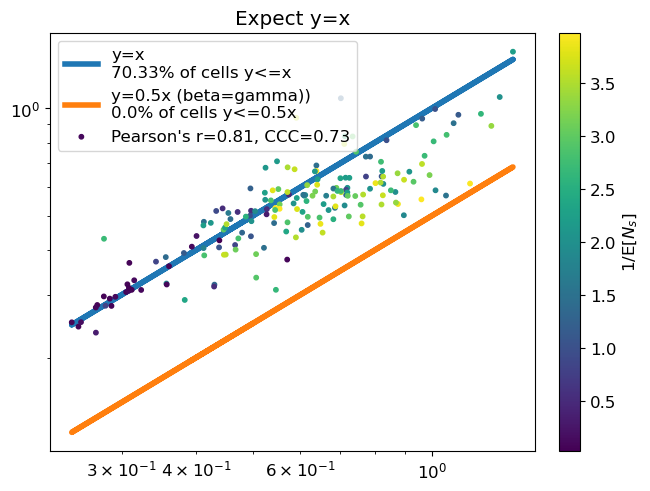

In [439]:
x=zeta_ss
y=zeta_us

plt.loglog(x,x,zorder=0,label='y=x\n'+str(np.around(100*(x>=y).mean(),2))+'% of cells y<=x')
plt.plot(x,x/2,zorder=0,label='y=0.5x (beta=gamma))\n'+str(np.around(100*(x>=2*y).mean(),2))+'% of cells y<=0.5x')
plt.scatter(x,y,s=10,alpha=1,c=1/S_mean,label="Pearson's r="+str(np.round(pearsonr(x,y).statistic,2))+", CCC="+str(np.round(CCC(x,y),2)))
plt.title("Expect y=x");
plt.colorbar(label=r'1/E[$N_s$]')
plt.legend()

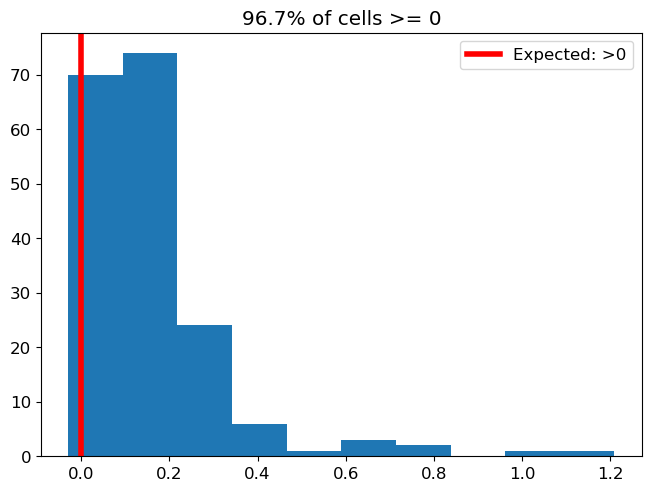

In [440]:
plt.hist((zeta_gs-zeta_us)*(zeta_us-zeta_uu));
plt.axvline(x=0,c='r',label='Expected: >0')
plt.title(str(np.around(100*((zeta_gs-zeta_us)*(zeta_us-zeta_uu)>=0).mean(),2))+'% of cells >= 0')
plt.legend()